In [1]:
!pip install shap stable-baselines3[extra] > /dev/null 2>&1

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import shap
import pickle

from sklearn.preprocessing import MinMaxScaler
from stable_baselines3 import PPO
from stable_baselines3.common.policies import obs_as_tensor
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

/usr/local/lib/python3.9/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.9/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_pa

In [3]:
train_og = pd.read_csv("/notebooks/ProcessedDataset/top001_train.csv")
test_og = pd.read_csv("/notebooks/ProcessedDataset/top001_test.csv")

train_enc = pd.read_csv("/notebooks/FinalDataset/top001_train_encoded.csv")
test_enc = pd.read_csv("/notebooks/FinalDataset/top001_test_encoded.csv")

x_train = train_enc.drop('attack_cat', axis=1)
y_train = train_enc['attack_cat']

x_train_og = train_og.drop('attack_cat', axis=1)
y_train_og = train_og['attack_cat']

x_test = test_enc.drop('attack_cat', axis=1)
y_test = test_enc['attack_cat']

x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_train_og, y_train_og = shuffle(x_train_og, y_train_og, random_state=42)

model = PPO.load("/notebooks/Models/RL/RL_001_Balanced.zip", device="cpu")

target_names = ["Analysis", "Backdoors", "DoS", "Exploits", "Fuzzers", 
                "Generic", "Reconnaissance", "Shellcode", "Worms"]

In [4]:
def rl_prediction(state):
    obs = obs_as_tensor(state, model.policy.device)
    dis = model.policy.get_distribution(obs)
    probs = dis.distribution.probs
    probs_np = probs.detach().numpy()
    return probs_np 
    res, _ = model.predict(state, deterministic=True)
    return res

with open("/notebooks/Utils/SHAP_explainer.pkl", "rb") as file:
    SHAP_explainer = pickle.load(file)

## Individual, disaggregated features

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

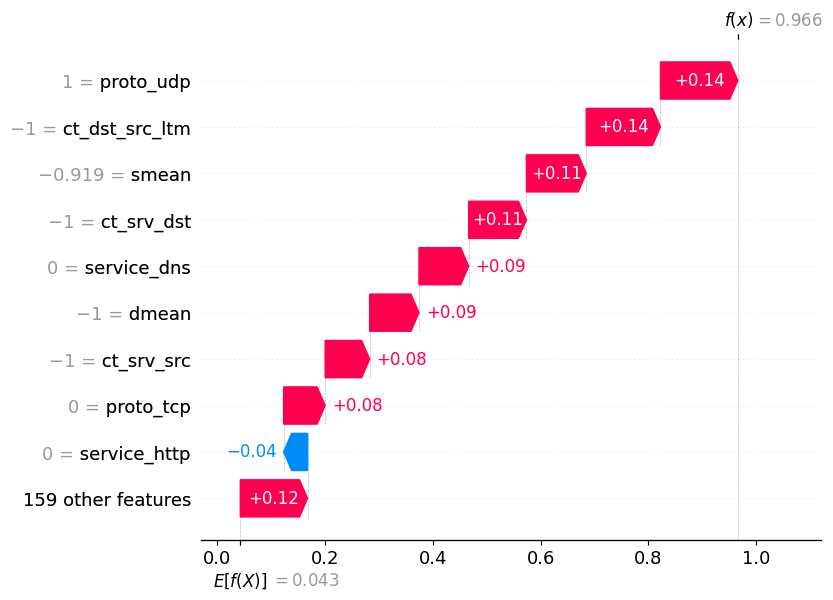

In [7]:
sample_id = 3

y_pred, _ = model.predict(x_train.iloc[sample_id], deterministic=True)

shap_values = SHAP_explainer.shap_values(x_train.iloc[sample_id].values, normalize=False)

exp = shap.Explanation(shap_values[y_pred],
                       SHAP_explainer.expected_value[y_pred],
                       data=x_train.iloc[sample_id].values,
                       feature_names=x_train.columns.tolist())

shap.plots.waterfall(exp, max_display=10)

## Individual, aggregated features

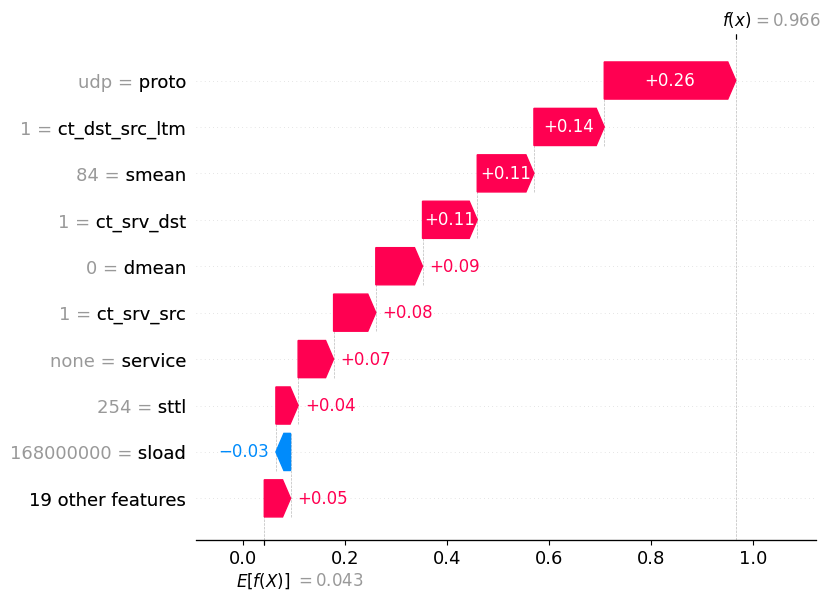

In [8]:
sample_id = 3

cleaned_cols = x_train_og.columns.tolist()
processed_cols = x_train.columns.tolist()

new_values = []

for f in cleaned_cols:
    tmp = 0
    for idx, p in enumerate(processed_cols):
        if p.startswith(f):
            tmp += shap_values[y_pred][idx]
    new_values.append(tmp)

new_values = np.asarray(new_values, np.float32)

exp = shap.Explanation(new_values, 
                       SHAP_explainer.expected_value[y_pred], 
                       data=x_train_og.iloc[sample_id].values,
                       feature_names=cleaned_cols)

shap.plots.waterfall(exp, max_display=10)